In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, num_heads=4, hidden_dim=512,
                 num_layers=2, max_len=512, dropout=0.1):
        super(TransformerLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout=dropout, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        seq_len = x.size(1)
        x = self.embedding(x)
        x = self.pos_encoder(x)

        # Generate causal mask: shape (seq_len, seq_len)
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)
        x = self.transformer_encoder(x, mask=mask)

        logits = self.fc(x)
        return logits, None

    def sample_with_temperature(self, x, temperature=1.0, max_len=50, eos_token_id=3, top_k=50):
        self.eval()
        generated = x.tolist()[0]
        input_tensor = x
        with torch.no_grad():
            for _ in range(max_len):
                logits, _ = self.forward(input_tensor)
                logits = logits[:, -1, :] / temperature
                logits = self.top_k_logits(logits, top_k)
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()
                if next_token == eos_token_id:
                    break
                generated.append(next_token)
                input_tensor = torch.tensor([generated], dtype=torch.long).to(x.device)
        return generated

    @staticmethod
    def top_k_logits(logits, k):
        values, _ = torch.topk(logits, k)
        min_values = values[:, -1].unsqueeze(1)
        return torch.where(logits < min_values, torch.full_like(logits, float('-inf')), logits)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sentencepiece as spm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import json
import torch
from torch.utils.data import Dataset
import sentencepiece as spm

import gdown

def download_from_drive(file_id, output_path):
    if not os.path.exists(output_path):
        url = f"https://drive.google.com/uc?id={file_id}"
        print(f"Downloading {output_path} from Google Drive...")
        gdown.download(url, output_path, quiet=False)
        
    
class TextDataset(Dataset):
    def __init__(self, file_path, sp_model_path, max_len=512):
        self.data = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                obj = json.loads(line)
                prompt = obj.get('prompt', '').strip()
                completion = obj.get('completion', '').strip()
                if prompt or completion:
                    full_text = (prompt + " " + completion).strip()
                    self.data.append(full_text)

        # Load the trained SentencePiece BPE model
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(sp_model_path)
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]
        token_ids = self.sp.encode(text, out_type=int)[:self.max_len]

        # Prepare input-output for language modeling
        input_ids = torch.tensor(token_ids[:-1], dtype=torch.long)
        target_ids = torch.tensor(token_ids[1:], dtype=torch.long)
        return input_ids, target_ids

def collate_batch(batch):
    inputs, targets = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets = pad_sequence(targets, batch_first=True, padding_value=0)
    return inputs, targets

def evaluate_validation_loss(model, val_loader, criterion, vocab_size):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)
            outputs = outputs.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(val_loader)

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, vocab_size,
          epochs=30, early_stopping_patience=5):
    model.to(device)
    best_val_loss = float("inf")
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            outputs = outputs.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        val_loss = evaluate_validation_loss(model, val_loader, criterion, vocab_size)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "transformer_model_best.pt")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"[Early stopping] No improvement for {early_stopping_patience} epochs.")
                break

    return train_losses, val_losses

def plot_loss(train_losses, val_losses, model_name="Transformer"):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f"{model_name} Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{model_name}_loss_curve.png")
    plt.show()

def top_k_logits(logits, k):
    values, _ = torch.topk(logits, k)
    min_values = values[:, -1].unsqueeze(1)
    return torch.where(logits < min_values, torch.full_like(logits, float('-inf')), logits)

def generate_with_temperature(model, sp, prompt, temperature=1.0, max_len=50, top_k=50):
    model.eval()
    input_ids = sp.encode(prompt, out_type=int)
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
    generated = input_ids.copy()

    with torch.no_grad():
        for _ in range(max_len):
            logits, _ = model(input_tensor)
            logits = logits[:, -1, :] / temperature
            logits = top_k_logits(logits, top_k)
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
            if next_token == sp.eos_id():
                break
            generated.append(next_token)
            input_tensor = torch.tensor([generated], dtype=torch.long).to(device)

    return sp.decode(generated)



/work/pegahnn/envs/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 - Train Loss: 5.6840 - Val Loss: 5.1293
Epoch 2/30 - Train Loss: 5.0491 - Val Loss: 4.8966
Epoch 3/30 - Train Loss: 4.8567 - Val Loss: 4.7892
Epoch 4/30 - Train Loss: 4.7415 - Val Loss: 4.7134
Epoch 5/30 - Train Loss: 4.6588 - Val Loss: 4.6693
Epoch 6/30 - Train Loss: 4.5934 - Val Loss: 4.6305
Epoch 7/30 - Train Loss: 4.5400 - Val Loss: 4.6037
Epoch 8/30 - Train Loss: 4.4954 - Val Loss: 4.5776
Epoch 9/30 - Train Loss: 4.4555 - Val Loss: 4.5604
Epoch 10/30 - Train Loss: 4.4207 - Val Loss: 4.5370
Epoch 11/30 - Train Loss: 4.3906 - Val Loss: 4.5237
Epoch 12/30 - Train Loss: 4.3616 - Val Loss: 4.5115
Epoch 13/30 - Train Loss: 4.3354 - Val Loss: 4.4992
Epoch 14/30 - Train Loss: 4.3116 - Val Loss: 4.4920
Epoch 15/30 - Train Loss: 4.2894 - Val Loss: 4.4774
Epoch 16/30 - Train Loss: 4.2683 - Val Loss: 4.4699
Epoch 17/30 - Train Loss: 4.2499 - Val Loss: 4.4607
Epoch 18/30 - Train Loss: 4.2314 - Val Loss: 4.4549
Epoch 19/30 - Train Loss: 4.2147 - Val Loss: 4.4531
Epoch 20/30 - Train L

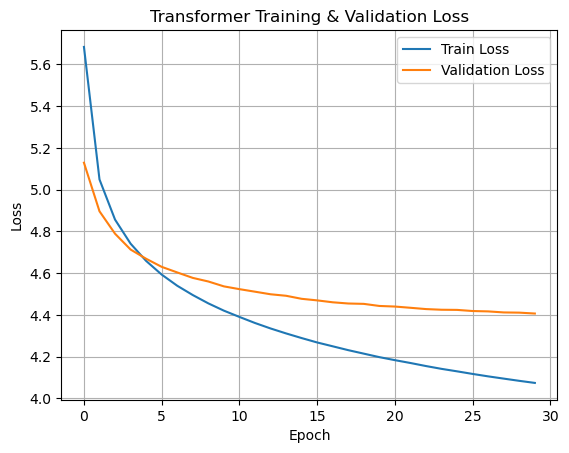


Prompt: Which do you prefer? Dogs or cats?
Generated: Which do you prefer? Dogs or cats? In that case of the people came to him because of one anothers nature, or in a state of mind the whole world, and then a little way from the house which has made their own master, but the other day will be considered to be able

Prompt: It was a dark and stormy night when
Generated: It was a dark and stormy night when he was still so heavy that the night was almost lugubrious enough of that sort was to be found out of this sort. One day he had been in the darkness. He was a man, and this man was in reality what he was before


In [6]:
if __name__ == "__main__":
    sp_model_path = "tokenizer/bpe.model"
    sp = spm.SentencePieceProcessor()
    sp.load(sp_model_path)

    # ⬇️ Download datasets from Google Drive if needed
    os.makedirs("data", exist_ok=True)
    download_from_drive("1NI1ZMYSAhtCFiZIg82tYqxNoETzOfs5D", "train.jsonl")
    download_from_drive("13OVMdyePf7jPXDGSRFlA_1riWiQQeWim", "test.jsonl")

    # ✅ Load datasets from local disk
    train_dataset = TextDataset("train.jsonl", sp_model_path)
    val_dataset = TextDataset("test.jsonl", sp_model_path)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

    vocab_size = 10000
    model = TransformerLanguageModel(
        vocab_size=vocab_size,
        embed_dim=256,
        num_heads=4,
        hidden_dim=512,
        num_layers=2,
        max_len=512,
        dropout=0.1
    )

    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    train_losses, val_losses = train(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        vocab_size, epochs=30, early_stopping_patience=5
    )

    torch.save(model.state_dict(), "transformer_model_final.pt")
    plot_loss(train_losses, val_losses, model_name="Transformer")

    sp = spm.SentencePieceProcessor()
    sp.load(sp_model_path)

    for prompt in [
        "Which do you prefer? Dogs or cats?",
        "It was a dark and stormy night when"
    ]:
        generated = generate_with_temperature(model, sp, prompt, temperature=0.8, top_k=50)
        print(f"\nPrompt: {prompt}\nGenerated: {generated}")




In [7]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import math

def evaluate_ppl(model, data_loader, criterion, vocab_size):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)
            outputs = outputs.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    ppl = math.exp(avg_loss)
    return ppl

def evaluate_bleu(model, dataset, sp, num_samples=50):
    model.eval()
    smoothie = SmoothingFunction().method4
    scores = []

    for i in range(min(len(dataset), num_samples)):
        full_text = dataset.data[i]
        prompt = full_text[:50]
        reference = full_text[50:100]
        input_ids = sp.encode(prompt, out_type=int)
        input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
        generated_ids = model.sample_with_temperature(input_tensor, temperature=1.0, max_len=50, eos_token_id=3, top_k=50)
        generated_text = sp.decode(generated_ids)

        # Compare generated text to the actual continuation
        score = sentence_bleu(
            [reference.split()],
            generated_text.split(),
            smoothing_function=smoothie
        )
        scores.append(score)

    return sum(scores) / len(scores)
# Evaluate on test set
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)
ppl = evaluate_ppl(model, test_loader, criterion, vocab_size)
bleu = evaluate_bleu(model, val_dataset, sp)

print(f"\nTest Perplexity: {ppl:.4f}")
print(f"Average BLEU Score (50 samples): {bleu:.4f}")




Test Perplexity: 82.0134
Average BLEU Score (50 samples): 0.0078
